# Near-duplicate image search

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/09/10<br>
**Last modified:** 2021/09/10<br>
**Description:** Building a near-duplicate image search utility using deep learning and locality-sensitive hashing.

## Introduction

Fetching similar images in (near) real time is an important use case of information
retrieval systems. Some popular products utilizing it include Pinterest, Google Image
Search, etc. In this example, we will build a similar image search utility using
[Locality Sensitive Hashing](https://towardsdatascience.com/understanding-locality-sensitive-hashing-49f6d1f6134)
(LSH) and [random projection](https://en.wikipedia.org/wiki/Random_projection) on top
of the image representations computed by a pretrained image classifier.
This kind of search engine is also known
as a _near-duplicate (or near-dup) image detector_.
We will also look into optimizing the inference performance of
our search utility on GPU using [TensorRT](https://developer.nvidia.com/tensorrt).

There are other examples under [keras.io/examples/vision](https://keras.io/examples/vision)
that are worth checking out in this regard:

* [Metric learning for image similarity search](https://keras.io/examples/vision/metric_learning)
* [Image similarity estimation using a Siamese Network with a triplet loss](https://keras.io/examples/vision/siamese_network)

Finally, this example uses the following resource as a reference and as such reuses some
of its code:
[Locality Sensitive Hashing for Similar Item Search](https://towardsdatascience.com/locality-sensitive-hashing-for-music-search-f2f1940ace23).

_Note that in order to optimize the performance of our parser,
you should have a GPU runtime available._

## Imports

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from skimage.feature import hog
import cv2

## Load the dataset and create a training set of 1,000 images

To keep the run time of the example short, we will be using a subset of 1,000 images from
the `tf_flowers` dataset (available through
[TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/tf_flowers))
to build our vocabulary.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

IMAGE_SIZE = 28
NUM_TRAIN_IMAGES = 6000

images = np.array(x_train[:NUM_TRAIN_IMAGES])
labels = np.array(y_train[:NUM_TRAIN_IMAGES])

print(images.shape)
print(labels.shape)

(6000, 28, 28)
(6000,)


## Load a pre-trained model

In this section, we load an image classification model that was trained on the
`tf_flowers` dataset. 85% of the total images were used to build the training set. For
more details on the training, refer to
[this notebook](https://github.com/sayakpaul/near-dup-parser/blob/main/bit-supervised-training.ipynb).

The underlying model is a BiT-ResNet (proposed in
[Big Transfer (BiT): General Visual Representation Learning](https://arxiv.org/abs/1912.11370)).
The BiT-ResNet family of models is known to provide excellent transfer performance across
a wide variety of different downstream tasks.

In [3]:
# !wget -q https://git.io/JuMq0 -O D:\CS530\near-duplicate\flower_model_bit_0.96875.zip
# !unzip -qq flower_model_bit_0.96875.zip

In [4]:
# bit_model = tf.keras.models.load_model("flower_model_bit_0.96875")
# bit_model.count_params()

## Create an embedding model

To retrieve similar images given a query image, we need to first generate vector
representations of all the images involved. We do this via an
embedding model that extracts output features from our pretrained classifier and
normalizes the resulting feature vectors.

In [5]:
# embedding_model = tf.keras.Sequential(
#     [
#         tf.keras.layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
#         tf.keras.layers.Rescaling(scale=1.0 / 255),
#         bit_model.layers[1],
#         tf.keras.layers.Normalization(mean=0, variance=1),
#     ],
#     name="embedding_model",
# )

# embedding_model.summary()

# embedding_model = tf.keras.Sequential(
#     [
#         tf.keras.layers.Input((IMAGE_SIZE, IMAGE_SIZE)),
#         tf.keras.layers.Rescaling(scale=1.0 / 255),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Normalization(mean=0, variance=1),
#     ],
#     name="embedding_model",
# )

# embedding_model.summary()

cell_size = (8, 8)  # h x w in pixels
block_size = (2, 2)  # h x w in cells
nbins = 9  # number of orientation bins
imgshape = [28, 28]
hog = cv2.HOGDescriptor(_winSize=(imgshape[1] // cell_size[1] * cell_size[1],
                                  imgshape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

class HOG_extractor():
    def predict(image):
        im = np.resize(image, (28, 28))
        feature = hog.compute(im)
        return [feature]
    
embedding_model = HOG_extractor


Take note of the normalization layer inside the model. It is used to project the
representation vectors to the space of unit-spheres.

## Hashing utilities

In [6]:

def hash_func(embedding, random_vectors):
    embedding = np.array(embedding)

    # Random projection.
    bools = np.dot(embedding, random_vectors) > 0
    return [bool2int(bool_vec) for bool_vec in bools]


def bool2int(x):
    y = 0
    for i, j in enumerate(x):
        if j:
            y += 1 << i
    return y


The shape of the vectors coming out of `embedding_model` is `(2048,)`, and considering practical
aspects (storage, retrieval performance, etc.) it is quite large. So, there arises a need
to reduce the dimensionality of the embedding vectors without reducing their information
content. This is where *random projection* comes into the picture.
It is based on the principle that if the
distance between a group of points on a given plane is _approximately_ preserved, the
dimensionality of that plane can further be reduced.

Inside `hash_func()`, we first reduce the dimensionality of the embedding vectors. Then
we compute the bitwise hash values of the images to determine their hash buckets. Images
having same hash values are likely to go into the same hash bucket. From a deployment
perspective, bitwise hash values are cheaper to store and operate on.

## Query utilities

The `Table` class is responsible for building a single hash table. Each entry in the hash
table is a mapping between the reduced embedding of an image from our dataset and a
unique identifier. Because our dimensionality reduction technique involves randomness, it
can so happen that similar images are not mapped to the same hash bucket everytime the
process run. To reduce this effect, we will take results from multiple tables into
consideration -- the number of tables and the reduction dimensionality are the key
hyperparameters here.

Crucially, you wouldn't reimplement locality-sensitive hashing yourself when working with
real world applications. Instead, you'd likely use one of the following popular libraries:

* [ScaNN](https://github.com/google-research/google-research/tree/master/scann)
* [Annoy](https://github.com/spotify/annoy)
* [Vald](https://github.com/vdaas/vald)

In [7]:

class Table:
    def __init__(self, hash_size, dim):
        self.table = {}
        self.hash_size = hash_size
        self.random_vectors = np.random.randn(hash_size, dim).T

    def add(self, id, vectors, label):
        # Create a unique indentifier.
        entry = {"id_label": str(id) + "_" + str(label)}

        # Compute the hash values.
        hashes = hash_func(vectors, self.random_vectors)

        # Add the hash values to the current table.
        for h in hashes:
            if h in self.table:
                self.table[h].append(entry)
            else:
                self.table[h] = [entry]

    def query(self, vectors):
        # Compute hash value for the query vector.
        hashes = hash_func(vectors, self.random_vectors)
        results = []

        # Loop over the query hashes and determine if they exist in
        # the current table.
        for h in hashes:
            if h in self.table:
                results.extend(self.table[h])
        return results


In the following `LSH` class we will pack the utilities to have multiple hash tables.

In [8]:

class LSH:
    def __init__(self, hash_size, dim, num_tables):
        self.num_tables = num_tables
        self.tables = []
        for i in range(self.num_tables):
            self.tables.append(Table(hash_size, dim))

    def add(self, id, vectors, label):
        for table in self.tables:
            table.add(id, vectors, label)

    def query(self, vectors):
        results = []
        for table in self.tables:
            results.extend(table.query(vectors))
        return results


Now we can encapsulate the logic for building and operating with the master LSH table (a
collection of many tables) inside a class. It has two methods:

* `train()`: Responsible for building the final LSH table.
* `query()`: Computes the number of matches given a query image and also quantifies the
similarity score.

In [9]:

class BuildLSHTable:
    def __init__(
        self,
        prediction_model,
        concrete_function=False,
        hash_size=8,
        dim=144,
        num_tables=10,
    ):
        self.hash_size = hash_size
        self.dim = dim
        self.num_tables = num_tables
        self.lsh = LSH(self.hash_size, self.dim, self.num_tables)

        self.prediction_model = prediction_model
        self.concrete_function = concrete_function
        

    def train(self, training_files):
        for id, training_file in enumerate(training_files):
            # Unpack the data.
            image, label = training_file
            if len(image.shape) < 4:
                image = image[None, ...]

            # Compute embeddings and update the LSH tables.
            # More on `self.concrete_function()` later.
            if self.concrete_function:
                features = self.prediction_model(tf.constant(image))[
                    "normalization"
                ].numpy()
            else:
                features = self.prediction_model.predict(image)
            self.lsh.add(id, features, label)

    def query(self, image, verbose=True):
        # Compute the embeddings of the query image and fetch the results.
        if len(image.shape) < 4:
            image = image[None, ...]

        if self.concrete_function:
            features = self.prediction_model(tf.constant(image))[
                "normalization"
            ].numpy()
        else:
            features = self.prediction_model.predict(image)

        results = self.lsh.query(features)
        if verbose:
            print("Matches:", len(results))

        # Calculate Jaccard index to quantify the similarity.
        counts = {}
        for r in results:
            if r["id_label"] in counts:
                counts[r["id_label"]] += 1
            else:
                counts[r["id_label"]] = 1
        for k in counts:
            counts[k] = float(counts[k]) / self.dim
        return counts


## Create LSH tables

With our helper utilities and classes implemented, we can now build our LSH table. Since
we will be benchmarking performance between optimized and unoptimized embedding models, we
will also warm up our GPU to avoid any unfair comparison.

Now we can first do the GPU wam-up and proceed to build the master LSH table with
`embedding_model`.

In [10]:
training_files = zip(images, labels)
lsh_builder = BuildLSHTable(embedding_model)
lsh_builder.train(training_files)

# visulaize

In [11]:
for i in range(10): print(len(lsh_builder.lsh.tables[i].table))

86
51
93
93
67
77
110
135
124
55


In [12]:
def plot_images(images, labels):
    plt.figure(figsize=(20, 10))
    columns = 5
    for (i, image) in enumerate(images):
        ax = plt.subplot(len(images) // columns + 1, columns, i + 1)
        # if i == 0:
        #     ax.set_title("Query Image\n" + "Label: {}".format(labels[i]))
        # else:
        #     ax.set_title("Similar Image # " + str(i) + "\nLabel: {}".format(labels[i]))
       
        ax.set_title("Label: {}".format(labels[i]))
        plt.imshow(image.astype("int"))
        plt.axis("off")

def vi(lsh_builder):
  inx = 0
  for hash, entry in lsh_builder.lsh.tables[2].table.items():
      inx += 1
      if inx > 5:
         break
      print(hash)
      candidates = []
      labels = []
      for i, r in enumerate(entry):
        if i == 5: 
            break
        r = r['id_label']
        image_id, label = r.split("_")[0], r.split("_")[1]
        print(image_id, label)
        candidates.append(images[int(image_id)])
        labels.append(label)
      plot_images(candidates, labels)

164
0 9
15 9
18 6
19 4
22 4
166
1 0
3 3
4 0
16 1
17 0
167
2 0
37 2
64 0
67 0
91 3
165
5 2
8 5
11 9
54 2
104 6
109
6 7
30 5
41 7
46 7
52 7


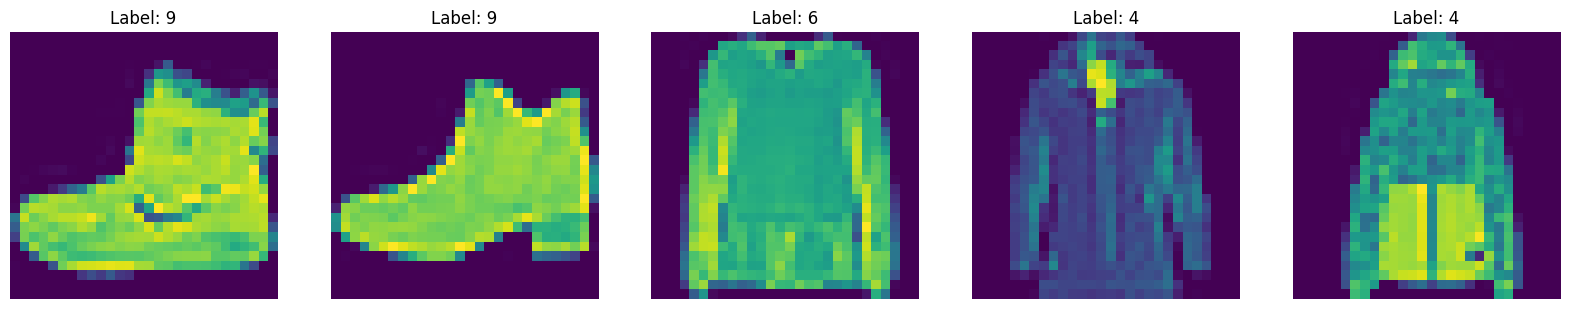

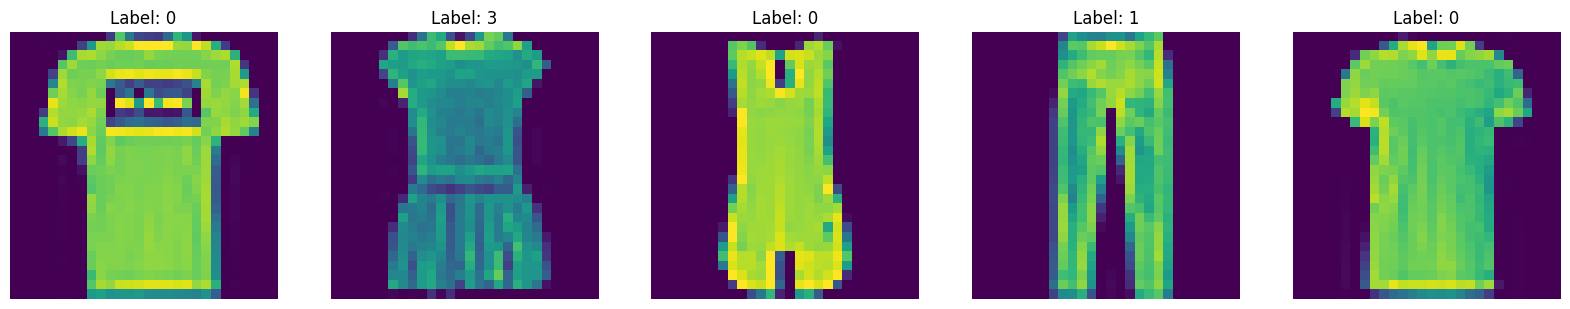

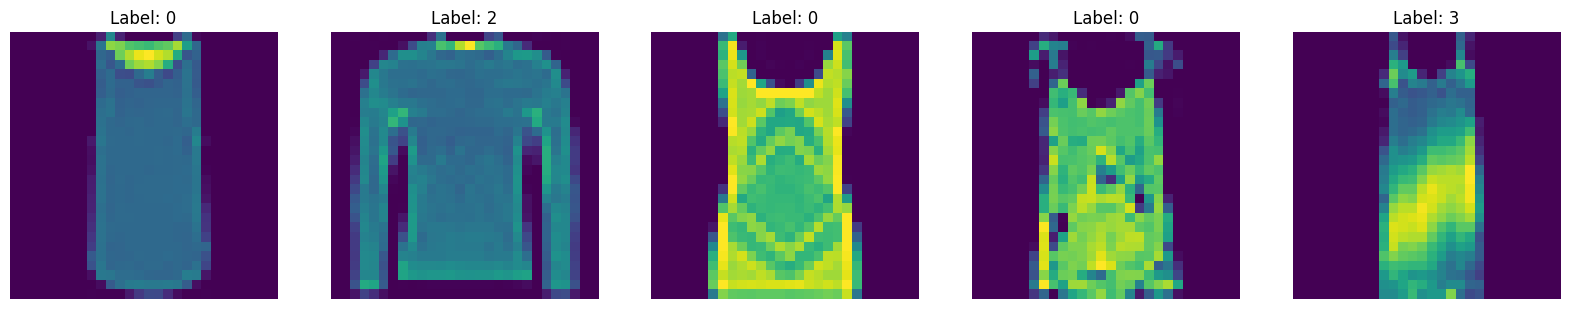

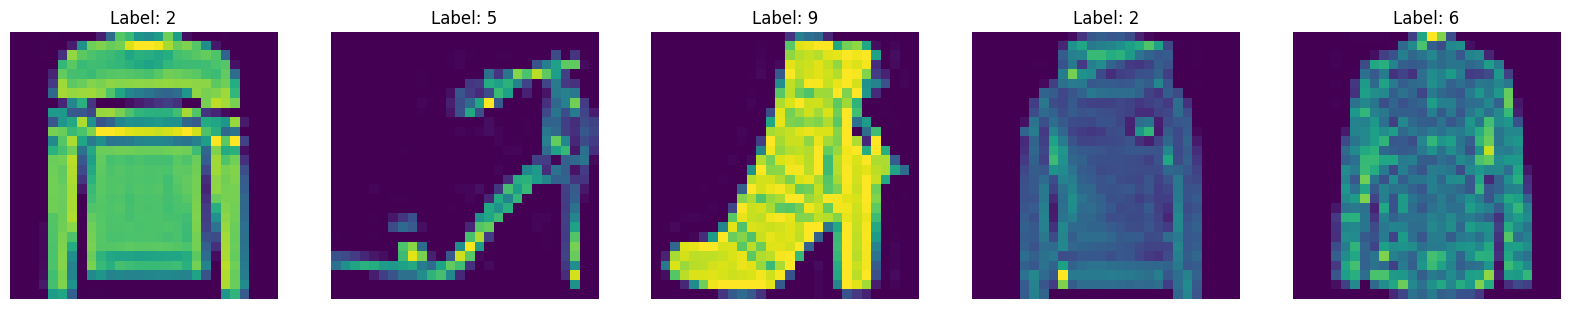

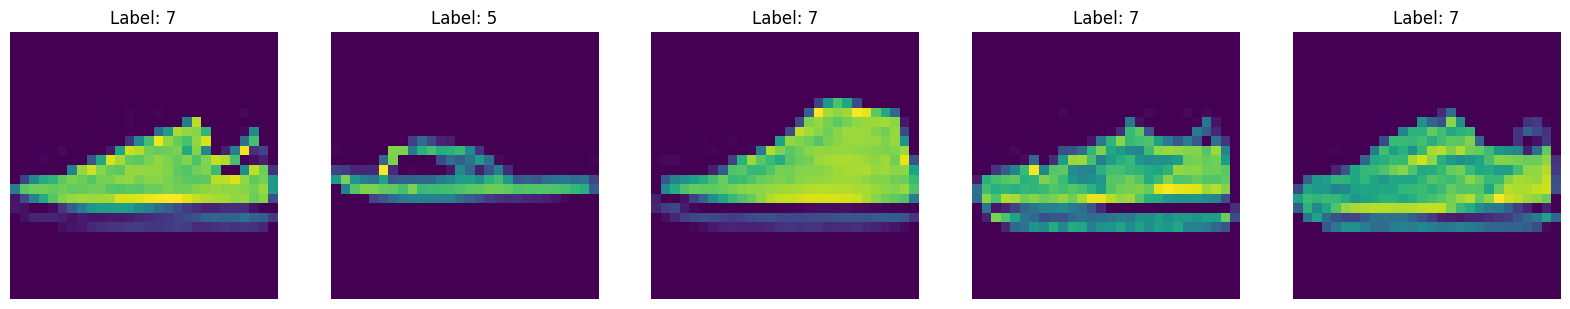

In [13]:
vi(lsh_builder)

At the time of writing, the wall time was 54.1 seconds on a Tesla T4 GPU. This timing may
vary based on the GPU you are using.

## Visualize results on validation images

In this section we will first writing a couple of utility functions to visualize the
similar image parsing process. Then we will benchmark the query performance of the models
with and without optimization.

First, we take 100 images from the validation set for testing purposes.

In [14]:
NUM_TEST_IMAGES = 1000

validation_images = x_test[:NUM_TEST_IMAGES]
validation_labels = y_test[:NUM_TEST_IMAGES]
print(validation_images.shape)
print(validation_labels.shape)

(1000, 28, 28)
(1000,)


Now we write our visualization utilities.

In [15]:

def plot_images(images, labels):
    plt.figure(figsize=(20, 10))
    columns = 5
    for (i, image) in enumerate(images):
        ax = plt.subplot(len(images) // columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(labels[i]))
        else:
            ax.set_title("Similar Image # " + str(i) + "\nLabel: {}".format(labels[i]))
        plt.imshow(image.astype("int"))
        plt.axis("off")


def visualize_lsh(lsh_class):
    idx = np.random.choice(len(validation_images))
    image = validation_images[idx]
    label = validation_labels[idx]
    results = lsh_class.query(image)

    candidates = []
    labels = []
    overlaps = []

    for idx, r in enumerate(sorted(results, key=results.get, reverse=True)):
        if idx == 4:
            break
        image_id, label = r.split("_")[0], r.split("_")[1]
        candidates.append(images[int(image_id)])
        labels.append(label)
        overlaps.append(results[r])

    candidates.insert(0, image)
    labels.insert(0, label)

    plot_images(candidates, labels)


### Non-TRT model

Matches: 10000
Matches: 3541
Matches: 4367
Matches: 2121
Matches: 5107
Matches: 4419


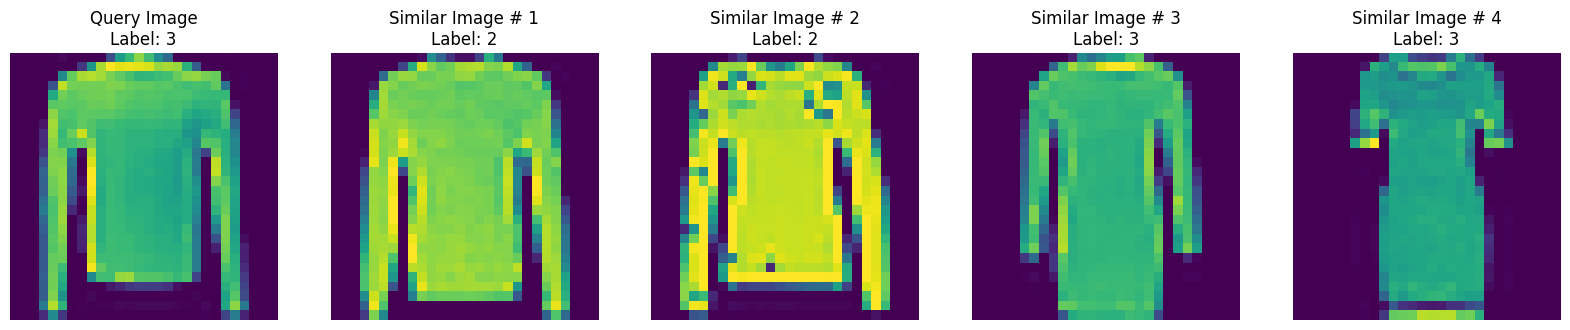

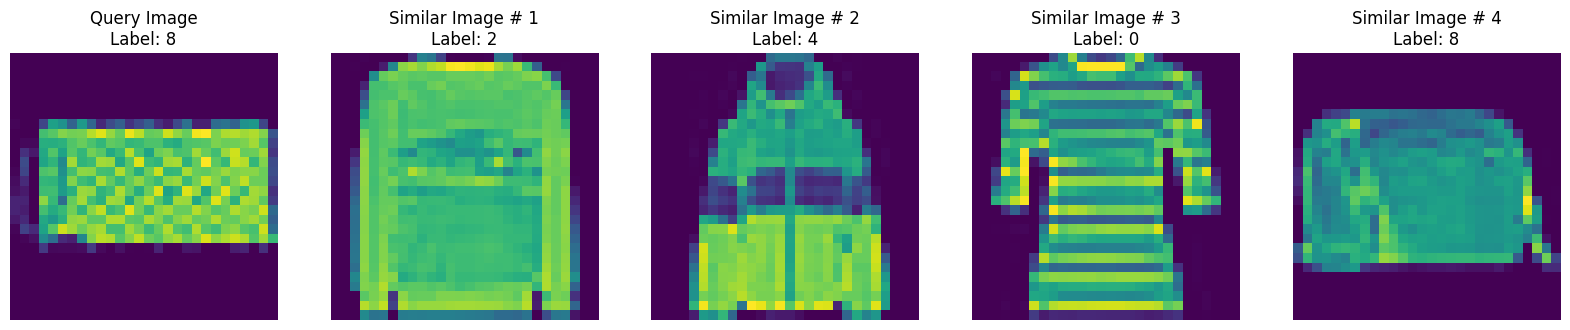

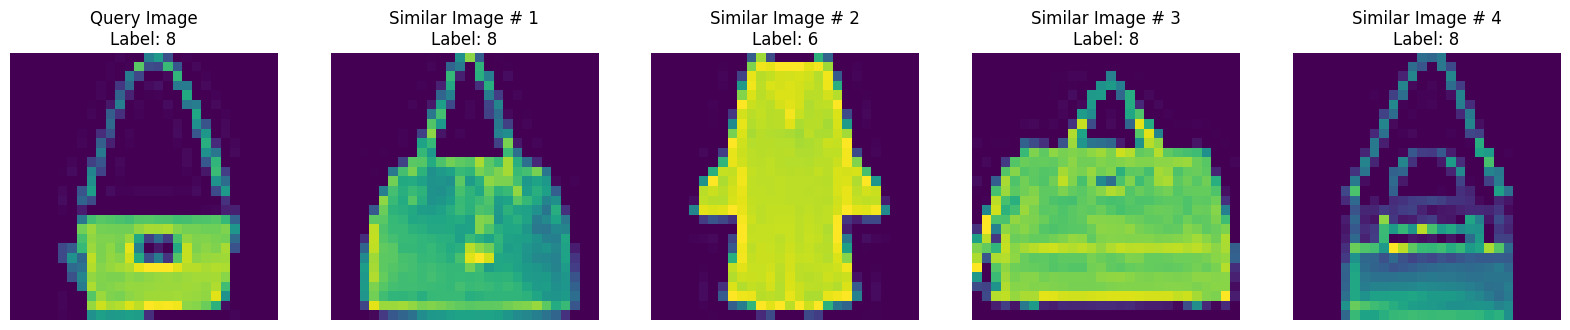

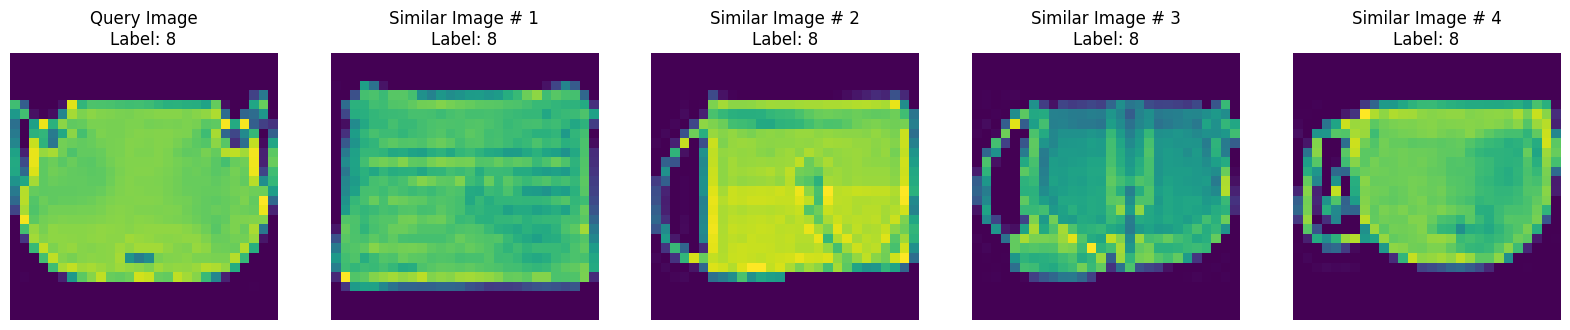

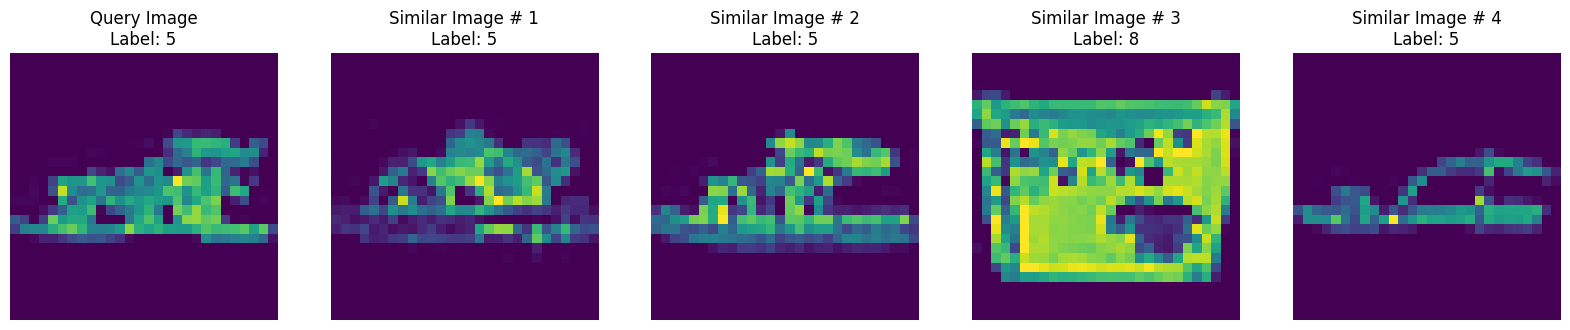

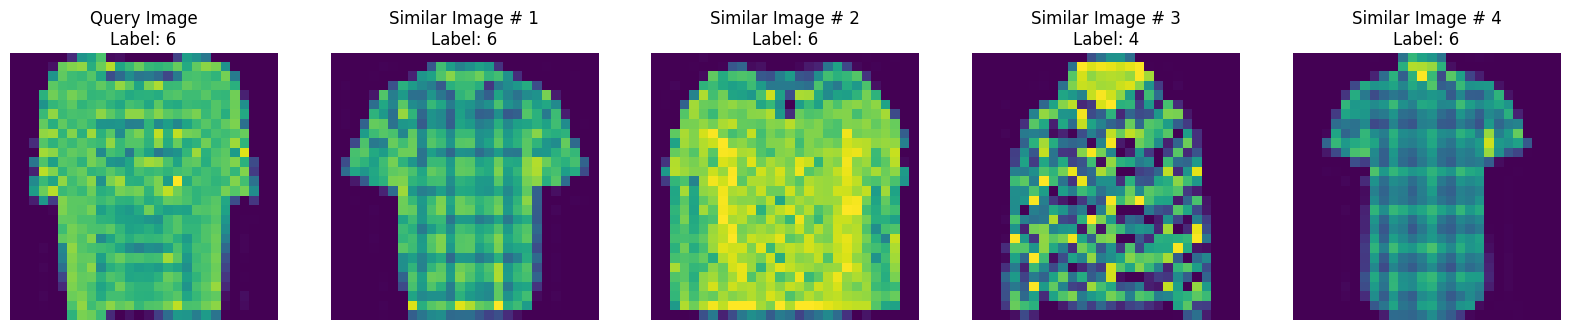

In [16]:
for _ in range(5):
    visualize_lsh(lsh_builder)

visualize_lsh(lsh_builder)

### TRT model

As you may have noticed, there are a couple of incorrect results. This can be mitigated in
a few ways:

* Better models for generating the initial embeddings especially for noisy samples. We can
use techniques like [ArcFace](https://arxiv.org/abs/1801.07698),
[Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362), etc.
that implicitly encourage better learning of representations for retrieval purposes.
* The trade-off between the number of tables and the reduction dimensionality is crucial
and helps set the right recall required for your application.

## Benchmarking query performance

We can immediately notice a stark difference between the query performance of the two
models.

## Final remarks

In this example, we explored the TensorRT framework from NVIDIA for optimizing our model.
It's best suited for GPU-based inference servers. There are other choices for such
frameworks that cater to different hardware platforms:

* [TensorFlow Lite](https://www.tensorflow.org/lite) for mobile and edge devices.
* [ONNX](hhttps://onnx.ai/) for commodity CPU-based servers.
* [Apache TVM](https://tvm.apache.org/), compiler for machine learning models covering
various platforms.

Here are a few resources you might want to check out to learn more
about applications based on vector similary search in general:

* [ANN Benchmarks](http://ann-benchmarks.com/)
* [Accelerating Large-Scale Inference with Anisotropic Vector Quantization(ScaNN)](https://arxiv.org/abs/1908.10396)
* [Spreading vectors for similarity search](https://arxiv.org/abs/1806.03198)
* [Building a real-time embeddings similarity matching system](https://cloud.google.com/architecture/building-real-time-embeddings-similarity-matching-system)